This is the implementation of real-vs-ai-generated images detection on CIFAKE dataset using vanilla CNN 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
seed = 123
tf.random.set_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
img_height = 32
img_width = 32
batch_size = 512
dataset_dir = "dataset/cifake/"

In [4]:
def load_data(dataset_dir, subset):
    """
    Load image data from a specific directory.
    """
    return tf.keras.utils.image_dataset_from_directory(
        f"{dataset_dir}/{subset}",
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True)

In [5]:
def create_vanilla_cnn_model():
    """
    Create and compile a CNN model.
    """
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    return model

In [6]:
def create_vit_model():
    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
    img_height = 224
    img_width = 224
    input_layer = layers.Input(shape=(img_height, img_width, 3))
    x = layers.Lambda(lambda img: tf.cast(tf.image.resize(img, (img_height, img_width)), tf.float32))(input_layer)
    x = layers.Lambda(lambda img: feature_extractor(img, return_tensors='tf').pixel_values, output_shape=[None, img_height, img_width, 3])(x)
    x = layers.Lambda(lambda x: vit_model(x).last_hidden_state[:, 0])(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [7]:
def train_model(model, train_val_ds, epochs=5, validation_split=0.2):
    """
    Train the model and plot the results.
    """
    val_samples = int(validation_split * train_val_ds.cardinality().numpy())
    train_ds = train_val_ds.skip(val_samples)
    val_ds = train_val_ds.take(val_samples)
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1
    )
    plot_training_history(history)
    return history

In [8]:
def plot_training_history(history):
    """
    Plot the accuracy and loss from the training history.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [9]:
def pipeline_vanilla_cnn():
    img_height = 32
    img_width = 32
    batch_size = 512
    dataset_dir = "dataset/cifake/"
    
    print("Loading dataset...")
    train_val_ds = load_data(dataset_dir, "train")
    test_ds = load_data(dataset_dir, "test")
    
    print("Creating model...")
    model = create_vanilla_cnn_model()
    model.summary()
    
    print("Starting training...")
    train_history = train_model(model, train_val_ds, epochs=5, validation_split=0.2)
    
    print("Evaluating on test set...")
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds, verbose=1)
    print('\nTest Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)
    print('Test Precision:', test_precision)
    print('Test Recall:', test_recall)
    
    # Optionally, save model weights
    model.save_weights('model_weights.h5')
    print("Model weights saved.")
    
    # Optionally, load model weights
    model.load_weights('model_weights.h5')
    print("Model weights loaded.")

In [10]:
train_vanilla_cnn=False
if train_vanilla_cnn==True:
    pipeline_vanilla_cnn()

In [12]:
print("Creating model...")
model = create_vanilla_cnn_model()
model.summary()
model.load_weights('models\model_weights_v1.h5')
print("Model weights loaded.")

Creating model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4,

In [25]:
from tensorflow.keras.preprocessing import image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_on_image(model, image_path):
    img = load_and_preprocess_image(image_path)
    predictions = model.predict(img)
    return predictions

# Example usage:
image_path = "dalle gen images/samp1.png"
predictions = predict_on_image(model, image_path)
print("Predictions:", predictions)
if predictions[0][0] < 0.5:
    print("Fake")
else:
    print("Not Fake")

1/1 [==============================] - 0s 90ms/step
Predictions: [[8.643904e-08]]
Fake


In [21]:

image_path = "dataset/cifake/test/FAKE/2.jpg"
predictions = predict_on_image(model, image_path)
print("Predictions:", predictions)
if predictions[0][0] < 0.5:
    print("Fake")
else:
    print("Not Fake")

1/1 [==============================] - 0s 108ms/step
Predictions: [[0.00270428]]
Fake


In [24]:
image_path = "dataset/cifake/test/REAL/0001.jpg"
predictions = predict_on_image(model, image_path)
print("Predictions:", predictions)
if predictions[0][0] < 0.5:
    print("Fake")
else:
    print("Not Fake")

1/1 [==============================] - 0s 57ms/step
Predictions: [[0.9805987]]
Not Fake


In [27]:
image_path = "dalle gen images/face.jpg"
predictions = predict_on_image(model, image_path)
print("Predictions:", predictions)
if predictions[0][0] < 0.5:
    print("Fake")
else:
    print("Not Fake")

1/1 [==============================] - 0s 110ms/step
Predictions: [[0.05203885]]
Fake


In [ ]:
image_path = "dalle gen images/face.jpg"
predictions = predict_on_image(model, image_path)
print("Predictions:", predictions)
if predictions[0][0] < 0.5:
    print("Fake")
else:
    print("Not Fake")

313/313 [==============================] - 7s 23ms/step


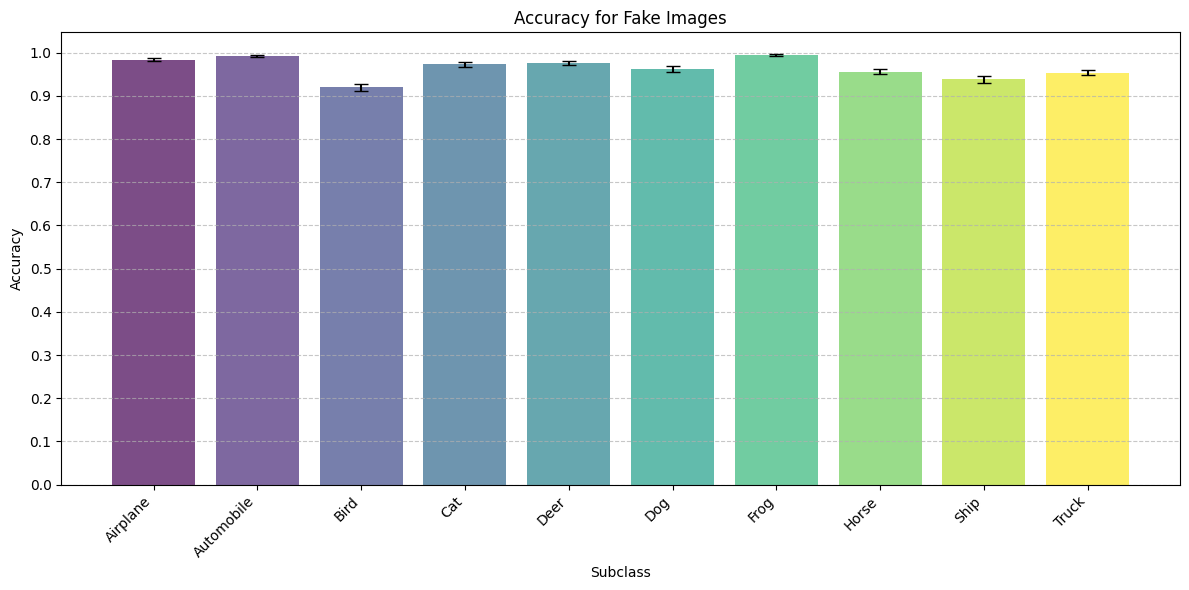

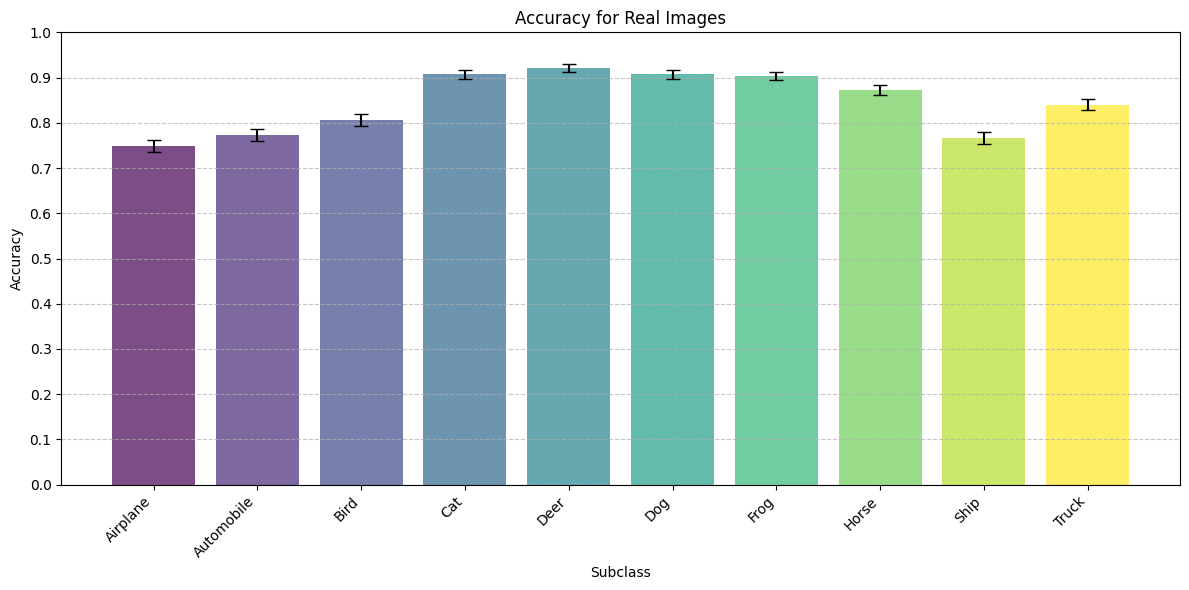

In [53]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model

# Define subclass names
subclass_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def get_subclass_label(image_path):
    """
    Extract class label from image path.
    """
    # Extract the base filename (without extension)
    base_filename = os.path.basename(image_path)
    
    # Split the filename by '(' and ')' to get the parts between parentheses
    parts = base_filename.split('(')[1:]
    # If there are no parentheses, the class label is 0 (background)
    if not parts:
        return 0
    
    # Extract the first part, remove ')' from the end, and convert to integer
    class_label = int(parts[0].split(')')[0])
    return class_label-1

def load_and_preprocess_images(image_paths):
    """
    Load and preprocess images from given paths.
    """
    images = [image.load_img(path, target_size=(32, 32)) for path in image_paths]
    img_arrays = [image.img_to_array(img) for img in images]
    return np.array(img_arrays)

def predict_on_images(model, image_paths):
    """
    Use the model to predict the images.
    """
    img_arrays = load_and_preprocess_images(image_paths)
    predictions = model.predict(img_arrays)
    return predictions

def plot_classwise_accuracy(predictions, true_labels, class_names, title, fake=False):
    """
    Plot accuracy for each subclass with enhancements.
    """
    # Define the condition based on whether the plot is for fake or real predictions
    condition = (predictions < 0.5) if fake else (predictions > 0.5)
    
    binary_predictions = condition.astype(int)  # 1 for predicted as Fake/Real according to the plot type
    subclass_accuracy = np.zeros(len(class_names))
    subclass_std = np.zeros(len(class_names))  # For error bars
    
    for i in range(len(class_names)):
        subclass_indices = np.where(true_labels == i)[0]
        if subclass_indices.size > 0:
            correct_predictions = binary_predictions[subclass_indices] == 1  # True if prediction matches the label for Real/Fake
            subclass_accuracy[i] = np.mean(correct_predictions)
            subclass_std[i] = np.std(correct_predictions) / np.sqrt(subclass_indices.size)  # Standard error

    colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))  # Using a color map for better color distribution
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, subclass_accuracy, color=colors, yerr=subclass_std, capsize=5, alpha=0.7)
    plt.xlabel('Subclass')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(np.linspace(0, 1, 11))  # Uniform y-axis ticks from 0 to 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
# Paths to the images
fake_image_paths = glob.glob("dataset/cifake/test/FAKE/*")
real_image_paths = glob.glob("dataset/cifake/test/REAL/*")

# Class labels for images based on their subclass
fake_labels = np.array([get_subclass_label(path) for path in fake_image_paths])
real_labels = np.array([get_subclass_label(path) for path in real_image_paths])

# Make predictions
fake_predictions = predict_on_images(model, fake_image_paths)
real_predictions = predict_on_images(model, real_image_paths)

# Plot class-wise accuracy
plot_classwise_accuracy(fake_predictions, fake_labels, subclass_names, 'Accuracy for Fake Images', fake=True)
plot_classwise_accuracy(real_predictions, real_labels, subclass_names, 'Accuracy for Real Images', fake=False)

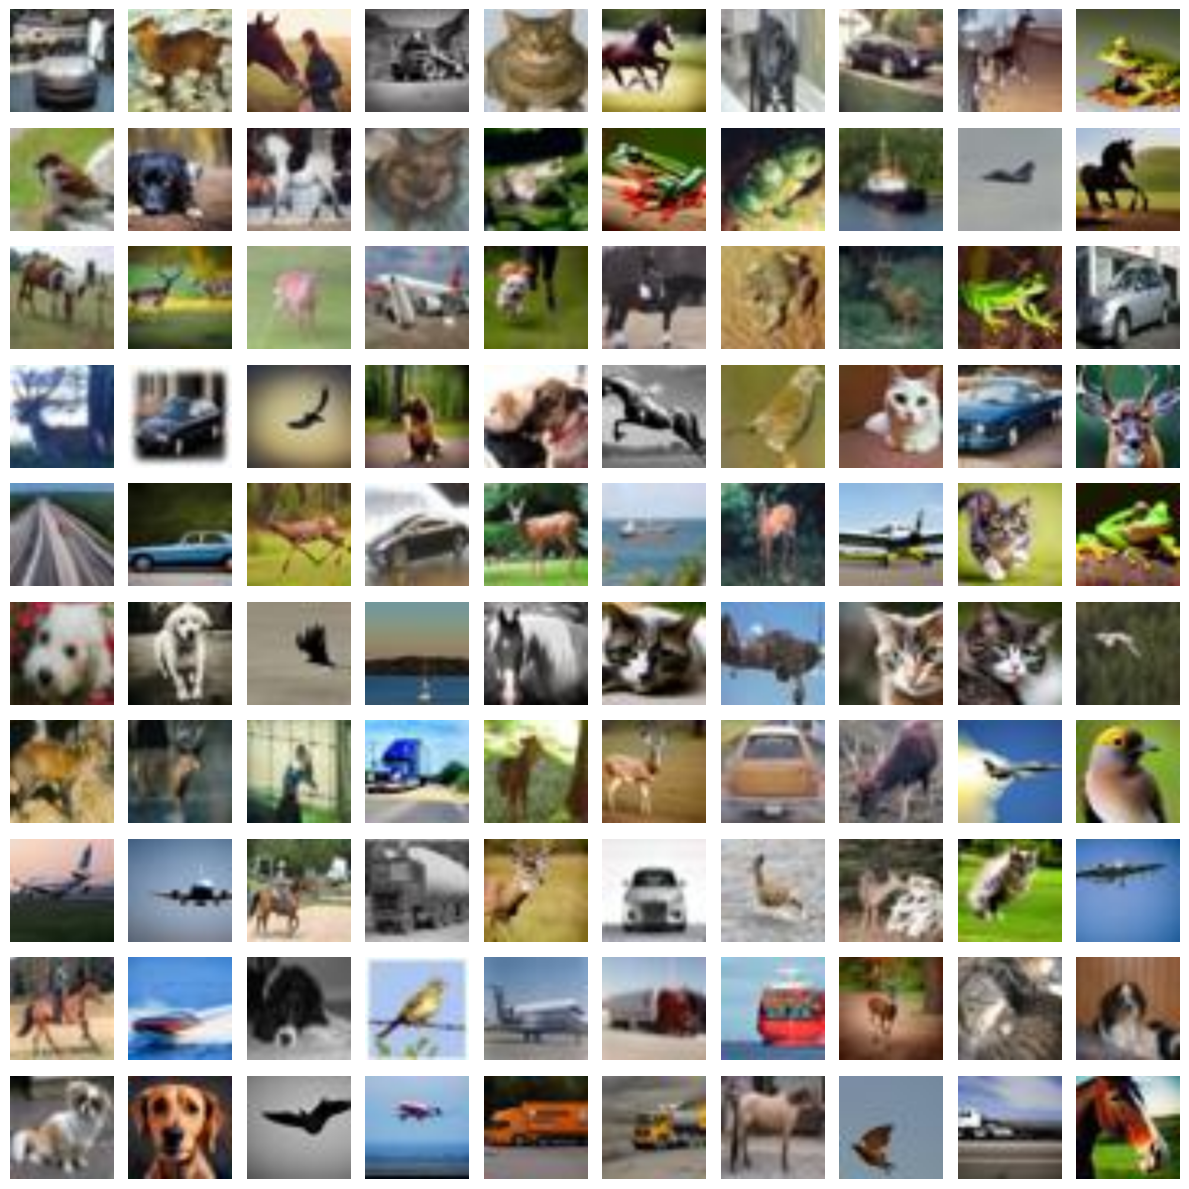

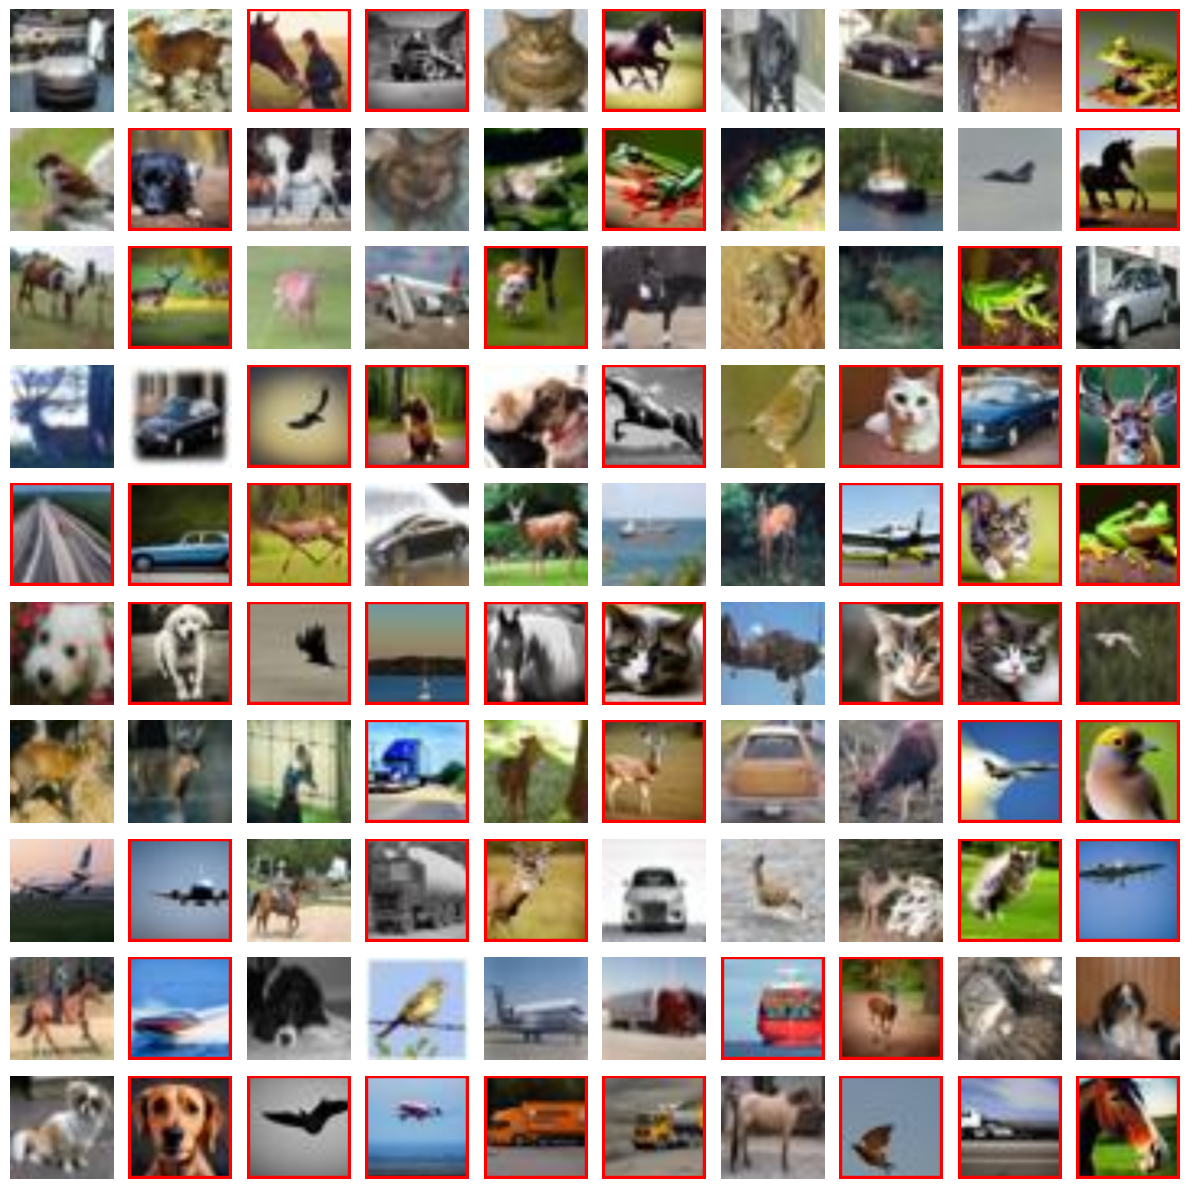

In [65]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import random

def create_labeled_image(path, label, size=(128, 128), draw_border=False):
    # Open the image and resize
    img = Image.open(path).resize(size, Image.BILINEAR)
    # Optionally draw a border
    if draw_border and label == 'Fake':
        draw = ImageDraw.Draw(img)
        draw.rectangle([0, 0, img.width - 1, img.height - 1], outline="red", width=4)
    return np.array(img)

def plot_image_matrix(real_image_paths, fake_image_paths, grid_size=10, draw_border=False, filename='plot.png'):
    random.seed(42)  # Seed for reproducibility
    num_images_per_type = grid_size * grid_size // 2

    # Select random images from each set
    selected_real_images = random.sample(real_image_paths, num_images_per_type)
    selected_fake_images = random.sample(fake_image_paths, num_images_per_type)

    # Load, optionally add border, and convert images
    real_imgs = [create_labeled_image(img, 'Real', draw_border=draw_border) for img in selected_real_images]
    fake_imgs = [create_labeled_image(img, 'Fake', draw_border=draw_border) for img in selected_fake_images]

    # Combine and shuffle
    total_imgs = real_imgs + fake_imgs
    random.shuffle(total_imgs)

    # Plotting
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    for ax, img in zip(axes.flatten(), total_imgs):
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig(filename)  # Save the figure to a file

plot_image_matrix(real_image_paths, fake_image_paths, grid_size=10, draw_border=False, filename='plot_no_borders.png')
plot_image_matrix(real_image_paths, fake_image_paths, grid_size=10, draw_border=True, filename='plot_with_borders.png')


